In [1]:
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/drive/MyDrive
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling tensorboard-2.12.0:
      Successfully uninstalled tensorboard-2.12.0
  Attempting uninstall: keras
    Found e

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Set Up

In [2]:
# We now set the directory to access the data
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

# The folder with the data and this script should be saved in your drive.
script_name = 'CourseWork_v2.ipynb'
script_path = find(script_name, '/content/gdrive/My Drive')
#DIRECTORY = '.'#os.path.dirname(script_path)
# If your Drive is too large and the "find" function takes to much time, you can set the directory manually :

#SUMMARY_PATH = '/content/drive/MyDrive/MutualFundSummary'
#SUMMARY_LABELS_PATH = '/content/drive/MyDrive/MutualFundLabels.csv'

DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/content/drive/MyDrive', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/content/drive/MyDrive', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

# Data Preprocessing

In [4]:
# read data
#labels = pd.read_csv('/content/MutualFundLabels.csv')
labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundLabels.csv')
labels = labels.drop('Performance fee?', axis=1)
removes = labels.loc[(labels['Ivestment Strategy']=='Long Short Funds (High Risk)')| (labels['Ivestment Strategy']=='Commodities Fund (Low Risk)')]
labels_clean = labels.drop(removes.index)

fund_names, summaries = get_data(SUMMARY_PATH)
cleaned_fund_names = labels_clean['fund_name'].tolist()
fund_name_counts = {name: 0 for name in fund_names}

for name in fund_names:
    if name in cleaned_fund_names:
        fund_name_counts[name] += 1

single_occurrences = {name: count for name, count in fund_name_counts.items() if count == 1}

print(f"Number of matching fund names that appear exactly once: {len(single_occurrences)}")

multiple_occurrences = {name: count for name, count in fund_name_counts.items() if count > 1}

if multiple_occurrences:
    print(f"There are fund names that appear more than once:")
    for name, count in multiple_occurrences.items():
        print(f"{name}: {count} times")
else:
    print("No fund names appear more than once.")

labels_clean_filtered = labels_clean[labels_clean['fund_name'].isin(fund_names)]

df_summaries = pd.DataFrame(data={'fund_name':fund_names, 'summary':summaries})

merge = labels_clean_filtered.merge(df_summaries, on=['fund_name'], how='left')

Number of matching fund names that appear exactly once: 461
No fund names appear more than once.


In [5]:
X, X_test, y, y_test = train_test_split(merge['summary'], merge['Ivestment Strategy'], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42)

In [6]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

# clean and tokenize without lemmatizing
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

train_text_words = np.concatenate([tokenizer(summary) for summary in X_train])

train_text_words[:20]

array(['mainstay', 'vp', 'epoch', 'u.s.', 'small', 'cap', 'portfolio',
       'investment', 'objective', 'portfolio', 'seeks', 'long-term',
       'capital', 'appreciation', 'investing', 'primarily', 'securities',
       'small-cap', 'companies', 'fees'], dtype='<U44')

# Skip-gram Model

In [7]:
# Training parameters
batch_size = 128
num_epochs = 2

# Word2vec parameters
embedding_size = 50
max_vocabulary_size = 5000
min_occurrence = 10
skip_window = 3
num_skips = 4

count = [('UNK', -1)]
count.extend(collections.Counter(train_text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        break

word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

data = list()
unk_count = 0
for word in train_text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [8]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    autoencoder = Model(input_word, decoded)
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2821)]            0         
                                                                 
 dense (Dense)               (None, 50)                141100    
                                                                 
 dense_1 (Dense)             (None, 2821)              143871    
                                                                 
Total params: 284971 (1.09 MB)
Trainable params: 284971 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2


<ipython-input-9-a9705c45700e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


3990/3990 [==============================] - 30s 7ms/step - loss: 0.0221
Epoch 2/2
3990/3990 [==============================] - 30s 7ms/step - loss: 0.0027


In [11]:
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

word2vec = {w : vecotrize(w) for w in word2id.keys()}
save_word2vec('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/train_word2vec')

1/1 [==============================] - 0s 24ms/step


In [13]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''","’"]+["]","[","*"]+['doe', 'ha', 'wa'] +['--']+ [''])

In [14]:
max_features = 18
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=list(stop_words), max_features=max_features)
tfidf_train = tfidf.fit_transform(X_train)
key_words = tfidf.get_feature_names_out() # 常用关键词

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
def get_n_closer(word, n, word2vec):
    vect = word2vec[word]
    dist_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    closer_words = []
    for _ in range(n):
        min_key = min(dist_dict.keys(), key=lambda k: dist_dict[k])
        closer_words.append(min_key)
        del dist_dict[min_key]
    return closer_words

##knowledge base
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

knowledge_base = create_knowledge_base(5, word2vec, key_words)
print(knowledge_base)

# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)



{'vehicles', 'portfolio/fund', 'fund', 'insurer', 'company', 'offered', 'sale', 'capped', 'underperforming', 'collectively', 'announced', 'concentrate', 'privately', 'effective', 'documents', 'frequency', 'later', 'experience', 'may', 'expense', 'creditworthiness', 'remains', 'forge', 'exposed', 'n', 'per', 'shown', 'shares', 'henderson', 'representatives', 'fee', 'year', 'performed', 'liquidity', 'market', 'tax', 'class', 'goods', 'subsequently', 'emerging-market', 'repayment', 'tolerate', 'unanticipated', 'favor', 'share', 'c', 'level', 'brian', 'response', 'index', 'institutions', 'low-rated', 'variable', 'focus', 'july', 'around', 'waddell', 'developers', 'end', 'incur', 'inability', 'performance', 'caused', 'return', 'portfolio', 'respect', 'float-adjusted', 'easing', 'lasalle', 'analysis', 'collateralize', 'logo', 'risk', 'events', 'initial', 'r', 'start', 'russell', 'investment', 'stated', 'value', 'impact', 'determine', 'concentration', 'primarily', 'security'}


# Measure Distance

In [ ]:
#prepare the train,validation and test dataframe
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_valid)
X_test_df = pd.DataFrame(X_test)

X_train_df['sentences_distance'] = X_train_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=20, n_reject=5, num_sent=15), axis=1)
X_valid_df['sentences_distance'] = X_valid_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=20, n_reject=5, num_sent=15), axis=1)
X_test_df['sentences_distance'] = X_test_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=20, n_reject=5, num_sent=15), axis=1)

In [ ]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

X_train_df['sentences_match'] = X_train_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=15), axis=1)
X_valid_df['sentences_match'] = X_valid_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=15), axis=1)
X_test_df['sentences_match'] = X_test_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=15), axis=1)

# produce train_X and test_X
train_X = X_train_df['sentences_match'].values
train_X = [' '.join(tokenizer(txt)) for txt in train_X]

valid_X = X_valid_df['sentences_match'].values
valid_X = [' '.join(tokenizer(txt)) for txt in valid_X]

test_X = X_test_df['sentences_match'].values
test_X = [' '.join(tokenizer(txt)) for txt in test_X]

# produce train_y and valid_y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()

encoded_train_y = encoder.fit_transform(y_train)
label_train_y = to_categorical(encoded_train_y, num_classes=3)

encoded_valid_y = encoder.transform(y_valid)
label_valid_y = to_categorical(encoded_valid_y, num_classes=3)

encoded_test_y = encoder.fit_transform(y_test)
label_test_y = to_categorical(encoded_test_y, num_classes=3)

num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

keras_tokenizer = Tokenizer(num_words=num_words)

keras_tokenizer.fit_on_texts(train_X)

word_index = keras_tokenizer.word_index

sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_valid = keras_tokenizer.texts_to_sequences(valid_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)

# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_valid = pad_sequences(sequences_valid, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

# create our embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# classifier

In [17]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return CNN

CNN_model = create_CNN_model()
CNN_history = CNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=100)


Epoch 1/800
3/3 [==============================] - 1s 11ms/step - loss: 1.1935 - accuracy: 0.3605
Epoch 2/800
3/3 [==============================] - 0s 12ms/step - loss: 1.0295 - accuracy: 0.5340
Epoch 3/800
3/3 [==============================] - 0s 12ms/step - loss: 0.9964 - accuracy: 0.5680
Epoch 4/800
3/3 [==============================] - 0s 11ms/step - loss: 0.9858 - accuracy: 0.5714
Epoch 5/800
3/3 [==============================] - 0s 13ms/step - loss: 0.9758 - accuracy: 0.5680
Epoch 6/800
3/3 [==============================] - 0s 11ms/step - loss: 0.9746 - accuracy: 0.5680
Epoch 7/800
3/3 [==============================] - 0s 11ms/step - loss: 0.9573 - accuracy: 0.5680
Epoch 8/800
3/3 [==============================] - 0s 10ms/step - loss: 0.9604 - accuracy: 0.5680
Epoch 9/800
3/3 [==============================] - 0s 11ms/step - loss: 0.9362 - accuracy: 0.5680
Epoch 10/800
3/3 [==============================] - 0s 12ms/step - loss: 0.9649 - accuracy: 0.5680
Epoch 11/800
3/3 [=

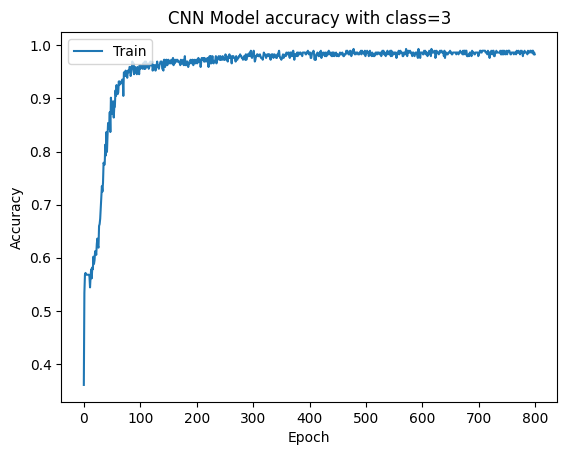

In [18]:
plt.plot(CNN_history.history['accuracy'])
plt.title('CNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

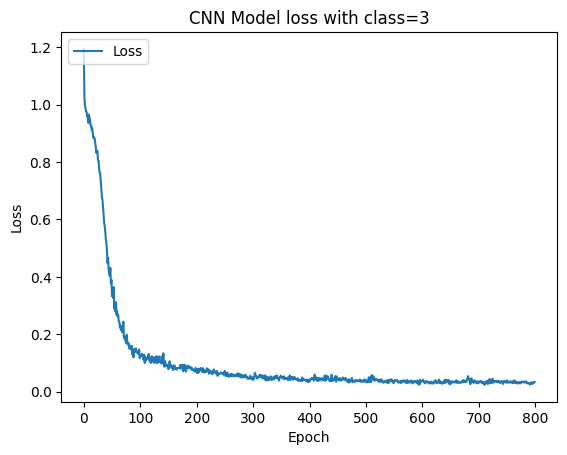

In [19]:
# Plot training loss values
plt.plot(CNN_history.history['loss'])
plt.title('CNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()


In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [21]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

3/3 [==============================] - 0s 4ms/step
0.6621621621621622
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.64      0.78      0.70        36
           2       0.67      0.52      0.59        23

   micro avg       0.66      0.66      0.66        74
   macro avg       0.68      0.63      0.65        74
weighted avg       0.67      0.66      0.66        74
 samples avg       0.66      0.66      0.66        74

auc score:  0.7183282933638275


In [22]:
y_test_CNN = CNN_model.predict(feature_test)
# convert the test vector
test_y_CNN = y_test_CNN.copy()
for i in range(len(y_test_CNN)):
    j = np.where(y_test_CNN[i] == np.amax(y_test_CNN[i]))
    test_y_CNN[i] = [0, 0, 0]
    test_y_CNN[i][j] = 1

print(accuracy_score(label_test_y,test_y_CNN))
print(classification_report(label_test_y,test_y_CNN))
print("auc score: ",roc_auc_score(label_test_y,test_y_CNN))

3/3 [==============================] - 0s 3ms/step
0.6774193548387096
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        17
           1       0.64      0.81      0.71        43
           2       0.86      0.55      0.67        33

   micro avg       0.68      0.68      0.68        93
   macro avg       0.69      0.65      0.66        93
weighted avg       0.71      0.68      0.67        93
 samples avg       0.68      0.68      0.68        93

auc score:  0.7342563441310652
